# Implementing Grover's Algorithm with Qiskit

Grover's algorithm is a quantum search algorithm that efficiently finds a target item in an unsorted database. It works by amplifying the probability of the correct answer through a series of quantum operations.

In this example, we will use Grover's algorithm to search for a specific binary string in a database, demonstrating a technique that can be applied to various search problems, including solving optimization tasks and finding specific solutions in large datasets.

In [1]:
import os
from qiskit_ibm_runtime import QiskitRuntimeService

# Retrieve the API token from the environment variable
api_token = os.environ.get("IBM_RPI_TOKEN")

# Initialize the QiskitRuntimeService
service = QiskitRuntimeService(channel='ibm_quantum', token=api_token)

# Set the backend to ibm_rensselaer
backend = service.backend("ibm_rensselaer")

In [3]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.circuit.library import GroverOperator
from qiskit.visualization import plot_histogram

# Import your database from the file
from database import database, target

In [4]:
def create_oracle(target):
    oracle = QuantumCircuit(len(target))
    for qubit, bit in enumerate(target):
        if bit == '0':
            oracle.x(qubit)
    oracle.h(len(target) - 1)
    oracle.mcx(list(range(len(target) - 1)), len(target) - 1)  # Multi-controlled Toffoli
    oracle.h(len(target) - 1)
    for qubit, bit in enumerate(target):
        if bit == '0':
            oracle.x(qubit)
    return oracle

In [5]:
# Number of qubits needed
n_qubits = len(database[0])

# Create a quantum circuit with one additional qubit for the ancilla
grover_circuit = QuantumCircuit(n_qubits)

# Apply Hadamard gates to all qubits to create a superposition
grover_circuit.h(range(n_qubits))

# Add the Oracle
oracle = create_oracle(target)
grover_circuit.compose(oracle, inplace=True)

# Apply the Grover diffusion operator (also known as the "amplification" operator)
grover_op = GroverOperator(oracle)
grover_circuit.compose(grover_op, inplace=True)

# Add measurement
grover_circuit.measure_all()

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler

# Assuming you've already set up your backend and service as before

# Transpile the circuit for the chosen backend
transpiled_circuit = transpile(grover_circuit, backend=backend)

# Use the new Sampler primitive to run the circuit
with Session(backend=backend) as session:
    sampler = Sampler()
    # Run the circuit using the sampler
    job = sampler.run(pubs=[transpiled_circuit], shots=1024)
    result = job.result()



AttributeError: 'PrimitiveResult' object has no attribute 'quasi_dists'

In [17]:
# Inspect the contents of _pub_results
print(result._pub_results)


[PubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}})]


In [18]:
# Assuming _pub_results is a list of results, inspect the first item
pub_result = result._pub_results[0]
print(pub_result)  # See what this contains


PubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}})


In [22]:
# Access the measurement data
bit_array = pub_result.data.meas

# Convert the BitArray to counts
# Get the counts as a dictionary
counts = bit_array.get_counts()  # or bit_array.get_int_counts() for integer keys


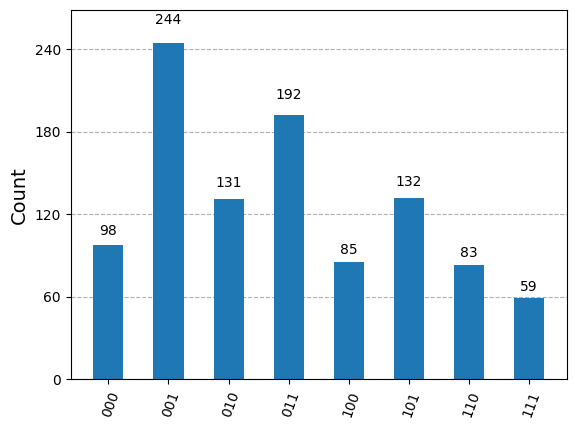

In [23]:
# Visualize the result
plot_histogram(counts)
